Goal: use a decision tree model to predict the relaxed energy of catalysts. 

Pipeline:
- data inspection & cleaning
- hot encoding (not all features are numeric) 
- correlation analysis (feature reduction) ??
- principal component analysis (for visualization) ??
- cross validation
- hyperparameter tuning & model selection
- final model evaluation
- feature importance
- exploitation

In [31]:
import pandas as pd
import matplotlib.pyplot as plt


h_X = pd.read_csv('data_clean/train_h_X_v1.csv')
h_y = pd.read_csv("data_clean/train_h_y.csv")

print(h_X.shape)
print(h_y.shape)

(1411, 93)
(1411, 1)


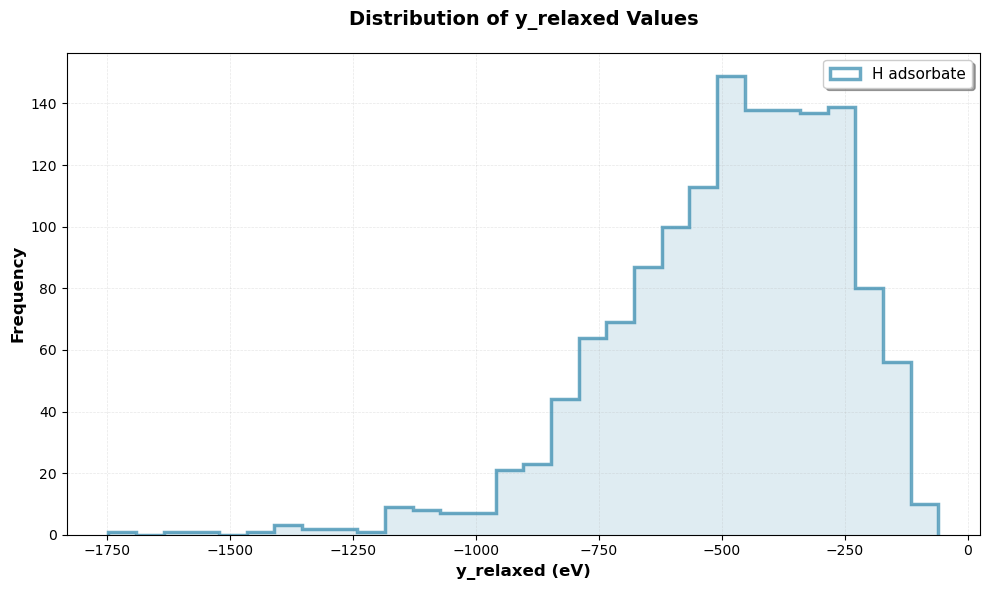

In [32]:
# Create figure with better size and resolution
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# Plot histograms as step curves (no overlap issues)
ax.hist(h_y, bins=30, alpha=0.7, color='#2E86AB', label='H adsorbate', histtype='step', linewidth=2.5)
# ax.hist(df_no_ads['y_relaxed'], bins=30, alpha=0.7, color='#F77F00', label='No adsorbate', histtype='step', linewidth=2.5)

# Optional: add fill under the lines for better visibility
ax.hist(h_y, bins=30, alpha=0.15, color='#2E86AB', histtype='stepfilled')
# ax.hist(df_no_ads['y_relaxed'], bins=30, alpha=0.15, color='#F77F00', histtype='stepfilled')

ax.set_xlabel('y_relaxed (eV)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of y_relaxed Values', fontsize=14, fontweight='bold', pad=20)

ax.legend(loc='upper right', frameon=True, shadow=True, fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

In [33]:
# Make sure X and y are aligned
print(len(h_X), len(h_y))
print(h_X.index.equals(h_y.index))

# print(len(no_ads_X), len(no_ads_y))
# print(no_ads_X.index.equals(no_ads_y.index))

1411 1411
True


In [34]:
# Check your target distribution
print(h_y.describe())
print(f"h_y has missing values? {h_y.isna().sum()}")  # Any missing values?
print(f"f_y has 0 values? {(h_y == 0).sum()}")  # Many zeros?

         y_relaxed
count  1411.000000
mean   -484.889476
std     229.531603
min   -1747.629416
25%    -619.847125
50%    -455.833953
75%    -314.403464
max     -59.024696
h_y has missing values? y_relaxed    0
dtype: int64
f_y has 0 values? y_relaxed    0
dtype: int64


## Cross Validation

simplest way is to use cross_val_score()
if cv argument is an integer, cross_val_score uses KFold or StratifiedKFold.
Can also use other cross alidation strategies by passing a cross validation iterator or by defining a custom iterable yielding (train, test) splits as arrays of indices.

cross_val_score vs. gridsearchCV?

In [35]:
from sklearn.model_selection import train_test_split

h_X_train, h_X_test, h_y_train, h_y_test = train_test_split(
    h_X, 
    h_y, 
    test_size=0.2, 
    random_state=1065)

# no_ads_X_train, no_ads_X_test, no_ads_y_train, no_ads_y_test = train_test_split(
#     encoded_no_ads_X, 
#     no_ads_y, 
#     test_size=0.2, 
#     random_state=1065)

In [36]:
from sklearn.dummy import DummyRegressor

h_baseline = DummyRegressor(strategy='mean')
h_baseline.fit(h_X_train, h_y_train)
print(f"h-ads Baseline R²: {h_baseline.score(h_X_train, h_y_train)}")

# no_ads_baseline = DummyRegressor(strategy='mean')
# no_ads_baseline.fit(no_ads_X_train, no_ads_y_train)
# print(f"no-ads Baseline R²: {h_baseline.score(no_ads_X_train, no_ads_y_train)}")

h-ads Baseline R²: 0.0


h-ads Linear Regression R²: 0.45868906471914106


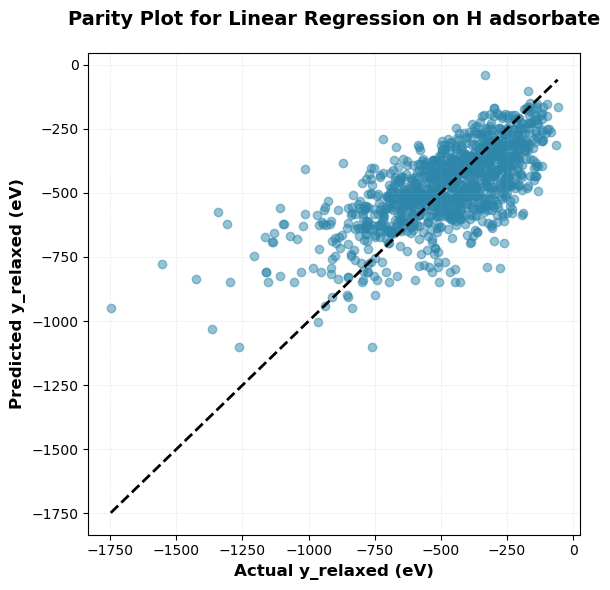

In [49]:
# linear regression
from sklearn.linear_model import LinearRegression, Lasso
model = LinearRegression()
model.fit(h_X_train, h_y_train)
print(f"h-ads Linear Regression R²: {model.score(h_X_train, h_y_train)}")

# create a parity plot
plt.figure(figsize=(6,6), dpi=100)
plt.scatter(h_y_train, model.predict(h_X_train), alpha=0.5, color='#2E86AB')
plt.plot([h_y_train.min(), h_y_train.max()], [h_y_train.min(), h_y_train.max()], 'k--', lw=2)
plt.xlabel('Actual y_relaxed (eV)', fontsize=12, fontweight='bold')
plt.ylabel('Predicted y_relaxed (eV)', fontsize=12, fontweight='bold')
plt.title('Parity Plot for Linear Regression on H adsorbate', fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

h_dt = DecisionTreeRegressor()
# no_ads_dt = DecisionTreeRegressor()

param_grid = {
    'max_depth' : [None, 3, 5, 7, 10, 15, 20],
    'min_samples_split' : [2, 4, 6, 8, 10, 12, 16, 18, 20],
    'min_samples_leaf' : [1, 2, 4, 5, 10, 15, 20],
    'max_features' : [None, 'sqrt', 'log2'],
}

h_grid = GridSearchCV(
    estimator=h_dt,
    param_grid = param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# no_ads_grid = GridSearchCV(
#     estimator=h_dt,
#     param_grid = param_grid,
#     scoring='r2',
#     cv=5,
#     n_jobs=-1,
#     verbose=1
# )

h_grid.fit(h_X_train, h_y_train)
# no_ads_grid.fit(no_ads_X_train, no_ads_y_train)

print('h-ads Best params: ', h_grid.best_params_)
# print('no-ads best params: ', no_ads_grid.best_params_)

# get tuned models
h_tuned_model = h_grid.best_estimator_
# no_ads_tuned_model = no_ads_grid.best_estimator_

# CV with tuned models
h_scores = cross_val_score(h_tuned_model, h_X_train, h_y_train, cv=5, scoring='r2')
# no_ads_scores = cross_val_score(no_ads_tuned_model, no_ads_X_train, no_ads_y_train, cv=5, scoring='r2')

Fitting 5 folds for each of 1323 candidates, totalling 6615 fits
h-ads Best params:  {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 20}


In [52]:
print("--- h-ads dataset ---")
print(f"h-ads training R²: {h_tuned_model.score(h_X_train, h_y_train)}")
print(f'h-ads CV R^2 scores: {h_scores}')
print(f"h-ads best CV R²: {h_grid.best_score_}")

# print("--- no-ads dataset ---")
# print(f"no-ads training R²: {no_ads_tuned_model.score(no_ads_X_train, no_ads_y_train)}")
# print(f'no-ads CV R^2 scores: {no_ads_scores}')
# print(f"no-ads best CV R²: {no_ads_grid.best_score_}")

--- h-ads dataset ---
h-ads training R²: 0.5562699348077895
h-ads CV R^2 scores: [0.23662905 0.29867555 0.33773419 0.26865013 0.29997887]
h-ads best CV R²: 0.28808072652240724


In [40]:
h_feature_importance = pd.DataFrame({
    'feature': h_X.columns,
    'importance': h_tuned_model.feature_importances_
}).sort_values('importance', ascending=False)

print(h_feature_importance.head(20))
print(f"\nTop 10 features capture {h_feature_importance.head(10)['importance'].sum():.2%} of importance")

                                            feature  importance
19                        MagpieData mean NUnfilled    0.420471
12                       MagpieData mean NsUnfilled    0.093387
4                          MagpieData mean MeltingT    0.081237
33                                           gap_AO    0.055091
8                               MagpieData mean Row    0.053217
40                  mean ordering parameter shell 1    0.050566
6                            MagpieData mean Column    0.037655
2                   MagpieData mean MendeleevNumber    0.036435
21                      MagpieData mean GSvolume_pa    0.033195
0                            MagpieData mean Number    0.029007
24                         MagpieData mean GSmagmom    0.021163
41                  mean ordering parameter shell 2    0.019234
39                         min relative bond length    0.018699
42                  mean ordering parameter shell 3    0.017364
14                       MagpieData mean

h-ads Test R²: 0.3018209587046019


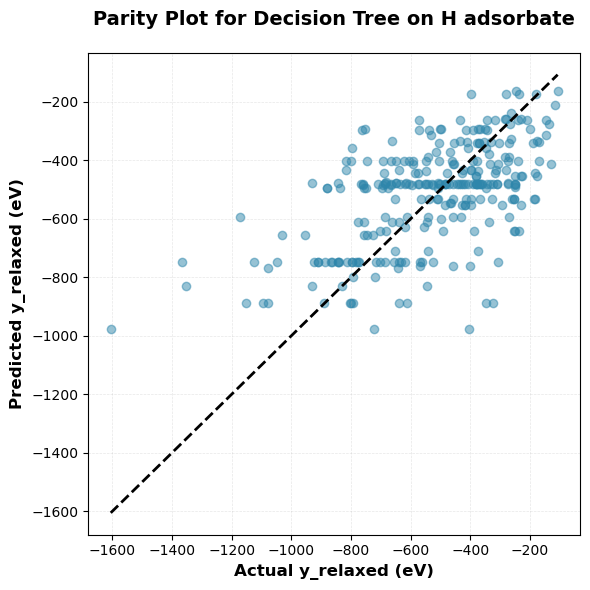

In [55]:
# fit and test tuned decision tree model
h_tuned_model.fit(h_X_train, h_y_train)
print(f"h-ads Test R²: {h_tuned_model.score(h_X_test, h_y_test)}")

# create parity plot
plt.figure(figsize=(6,6), dpi=100)
plt.scatter(h_y_test, h_tuned_model.predict(h_X_test), alpha=0.5, color='#2E86AB')
plt.plot([h_y_test.min(), h_y_test.max()], [h_y_test.min(), h_y_test.max()], 'k--', lw=2)
plt.xlabel('Actual y_relaxed (eV)', fontsize=12, fontweight='bold')
plt.ylabel('Predicted y_relaxed (eV)', fontsize=12, fontweight='bold')
plt.title('Parity Plot for Decision Tree on H adsorbate', fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Regression

Here I define the model pipeline that will be used for CV and final model evaluation.

In [41]:
# hot-encodes the categorical structure features.
# this code is generated by ChatGPT and I am not sure exactly how it works
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline


# get the part of the dataframe that is obj data type (which is a string)
is_obj = h_X.dtypes == 'object'
h_X_obj = h_X.loc[:, is_obj]

# OneHotCoder transforms each categorical feature with (n_categories) possible values
# into n_categories binary features.
h_preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), h_X_obj.columns)
    ],
    remainder='passthrough' # columns not specified in transformers will be untouched.
    # since we are only passing in the categorical columns, this shouldn't matter
)

# calling model.fit() and it will automatically encode the inputs
h_model = Pipeline([
    ('preprocess', h_preprocess),
    ('regression', DecisionTreeRegressor())])